In [33]:
from datetime import datetime
import pandas as pd
import numpy as np
import os
import json
import fnmatch
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
# Files path 
general=os.path.join("Output","General")
category=os.path.join("Output", "Category")
# Leagues
leagues=['MLB', 'MLS', 'NBA', 'NFL', 'NHL']

In [35]:
# Example: list for NFL, from "General" data
nfl_list=os.listdir(os.path.join(general, "NFL"))
nfl_list

['Arizona_Cardinals_restaurants.json',
 'Atlanta_Falcons_restaurants.json',
 'Baltimore_Ravens_restaurants.json',
 'Buffalo_Bills_restaurants.json',
 'Carolina_Panthers_restaurants.json',
 'Chicago_Bears_restaurants.json',
 'Cincinnati_Bengals_restaurants.json',
 'Cleveland_Browns_restaurants.json',
 'Dallas_Cowboys_restaurants.json',
 'Denver_Broncos_restaurants.json',
 'Detroit_Lions_restaurants.json',
 'Green_Bay_Packers_restaurants.json',
 'Houston_Texans_restaurants.json',
 'Indianapolis_Colts_restaurants.json',
 'Jacksonville_Jaguars_restaurants.json',
 'Kansas_City_Chiefs_restaurants.json',
 'Las_Vegas_Raiders_restaurants.json',
 'Los_Angeles_Chargers_restaurants.json',
 'Los_Angeles_Rams_restaurants.json',
 'Miami_Dolphins_restaurants.json',
 'Minnesota_Vikings_restaurants.json',
 'New_England_Patriots_restaurants.json',
 'New_Orleans_Saints_restaurants.json',
 'New_York_Giants_restaurants.json',
 'New_York_Jets_restaurants.json',
 'Philadelphia_Eagles_restaurants.json',
 'Pitt

In [36]:
# drop teams that play in the same stadium/duplicated cities
def remove_duplicated_city(inputList, dupList):
    drop_list=[]
    lista=inputList.copy()
    for v in lista:
        for d in dupList:
            if fnmatch.fnmatch(v, f'{d}*.json'):
                drop_list.append(v)
    for t in drop_list[1::2]:
        lista.remove(t)
    return lista    

In [37]:
# In case we want to remove the teams that play in the same stadium:
nfl_new_list=remove_duplicated_city(nfl_list, ['New_York', "Los_Angeles"])

## Let's have a look to the data in one file

In [38]:
#function to drop nan from a list
def drop_nan(_list):
    return [_ for _ in _list if _ is not np.nan]

In [ ]:
# map the price list to numeric values
def pricemap(alist):
    price_map= {"$": 1, "$$": 2, "$$$": 3, "$$$$": 4}
    for k, v in enumerate(alist):
        if v in price_map:
            alist[k]=price_map[v]

In [39]:
# Function to map the price from "$" to numeric values and also fill with nan if "price" key doesn't exist
def price_mapper(dictio):
    price_map= {"$": 1, "$$": 2, "$$$": 3, "$$$$": 4}
    for i in range(dictio['total']):
        if 'price' in dictio['businesses'][i] and dictio['businesses'][i]['price'] in price_map:
            dictio['businesses'][i]['price']=price_map[dictio['businesses'][i]['price']]
        else:
            dictio['businesses'][i]['price']=np.nan

In [40]:
# Function to open a json file
def openfile(filep):
    with open(filep, encoding="utf-8") as f:
        jsonData=json.load(f)
    return jsonData

In [46]:
# Function that returns a dataframe with price, ratings, reviews and number of businesses statistics for each stadium/arena
def restaurant_statistics(fileList, league, category=False):
    league_dict={}
    if category:
        folder=os.path.join("Output", "Category")
    else:
        folder=os.path.join("Output","General")
    for file in fileList:
        business_price=[]
        business_rating=[]
        business_reviews=[]
        file_path=os.path.join(folder, league, file)
        fileData=openfile(file_path)
        price_mapper(fileData)
        abs_total=fileData['absolute total']
        total=fileData['total']
        stadium=fileData['stadium']
        stadium_coord=[round(fileData['stadium latitude'],3), round(fileData['stadium longitude'],3)]
        for t in range(fileData['total']):
            business_price.append(fileData['businesses'][t]['price'])
            try:
                business_rating.append(fileData['businesses'][t]['rating'])
                business_reviews.append(fileData['businesses'][t]['review_count'])
            except:
                business_rating.append(np.nan)
                business_reviews.append(np.nan)    
    
        bprice=drop_nan(business_price)
        brating=drop_nan(business_rating)
        breview=drop_nan(business_reviews)
        league_dict[fileData['team']]=(stadium, stadium_coord, abs_total, np.mean(bprice), np.mean(brating), np.mean(breview))
    # Dataframe with the statistics    
    statistics_df = pd.DataFrame.from_dict(league_dict, orient = "index",
                           columns = ("Stadium", "Stadium coordinates", "Number of businesses", "Average Price (1-4)", "Average Ratings (1-5)", "Average Number of Reviews"))
    return statistics_df
        
    

In [47]:
# Dictionary with the statistics dataframe for each league
stats={}
for league in leagues:
    league_list=os.listdir(os.path.join(general, league))
    stats[league]=restaurant_statistics(league_list, league)
    # Drop teams that play in the same Stadium (NFL and NBA)
    stats[league].drop_duplicates(subset=['Stadium'], keep='first', inplace=True)

In [53]:
stats["MLB"]

,Stadium,Stadium coordinates,Number of businesses,Average Price (1-4),Average Ratings (1-5),Average Number of Reviews
Arizona Diamondbacks,Chase Field,"[33.445, -112.067]",305,1.522936,3.763934,215.668852
Atlanta Braves,Truist Park,"[33.89, -84.468]",248,1.541237,3.334677,141.483871
Baltimore Orioles,Oriole Park at Camden Yards,"[39.284, -76.622]",841,1.703770,3.630202,119.067776
Boston Red Sox,Fenway Park,"[42.346, -71.098]",1300,1.797511,3.765000,295.194000
Chicago Cubs,Wrigley Field,"[41.948, -87.656]",922,1.649664,3.777115,255.877440
Chicago White Sox,Guaranteed Rate Field,"[41.83, -87.634]",377,1.534884,3.542440,136.289125
Cincinnati Reds,Great American Ball Park,"[39.097, -84.507]",452,1.583333,3.768805,118.205752
Cleveland Indians,Progressive Field,"[41.496, -81.685]",419,1.692042,3.705251,106.634845
Colorado Rockies,Coors Field,"[39.756, -104.994]",853,1.703822,3.919109,232.243845
Detroit Tigers,Comerica Park,"[42.339, -83.049]",532,1.708861,3.617481,123.823308


## Bar Plots

In [104]:
def barPlot(league,df,col="Number of businesses", barcolor="b", save=True):
    sns.set_theme(context='notebook',style="whitegrid")
    f, ax=plt.subplots(figsize=(6,10))
    sns.set_color_codes("pastel")
    sns.barplot(x=col, y="Stadium", data=df, color=barcolor).set(title=f'{col} in 1.8 miles radius around {league} Stadiums')
    ax.set_xlabel(col,fontsize=14)
    ax.set_ylabel("Stadiums",fontsize=14)
    for index, value in enumerate(df[col]):
        plt.text(value,index, str(round(value,2)), horizontalalignment = "center", verticalalignment = "center")
    if save:
        plt.savefig(f'Images/{league}_{col}.png', bbox_inches = 'tight')
    plt.show()
    

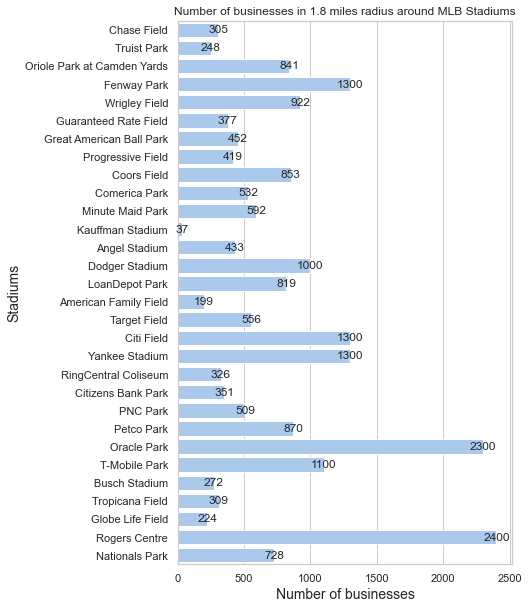

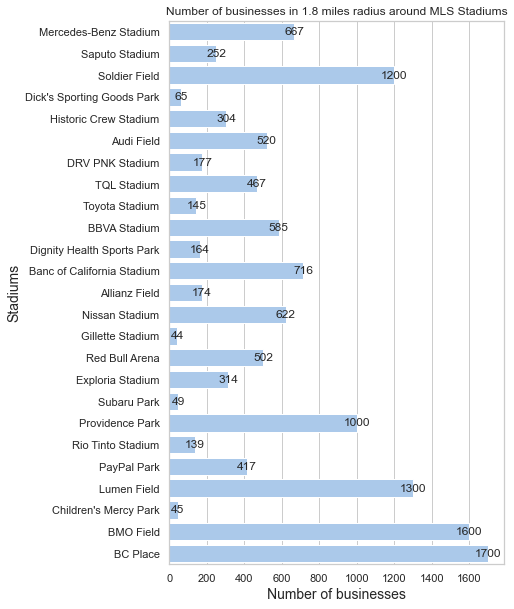

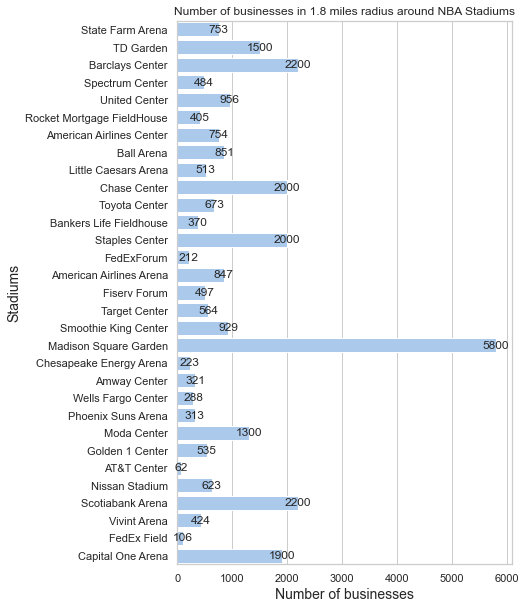

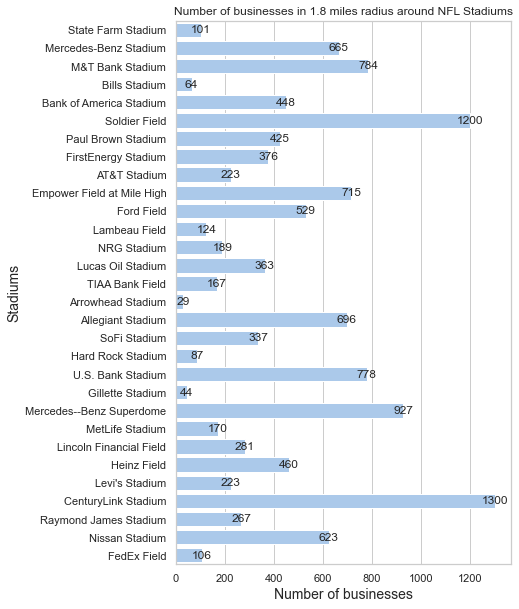

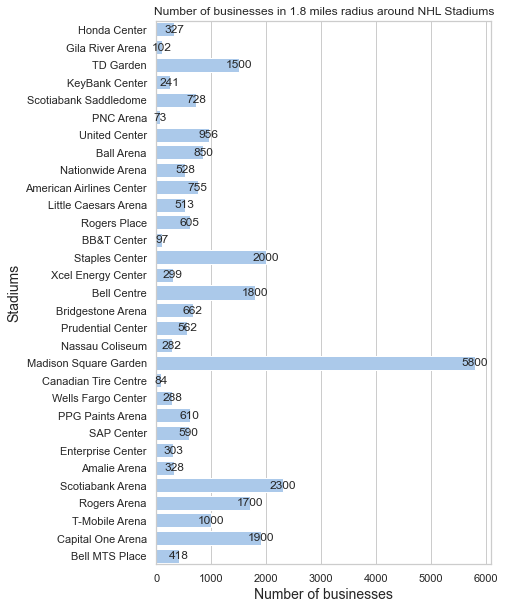

In [105]:
# Total Number of businesses
for k,v in stats.items():
    barPlot(k, v, col="Number of businesses", barcolor="b", save=False)

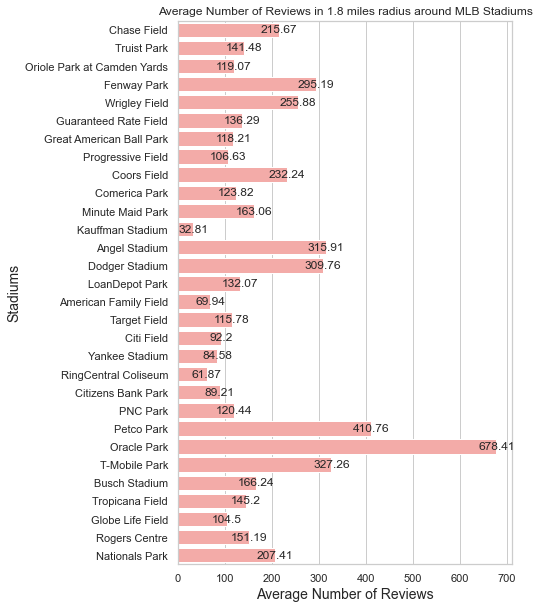

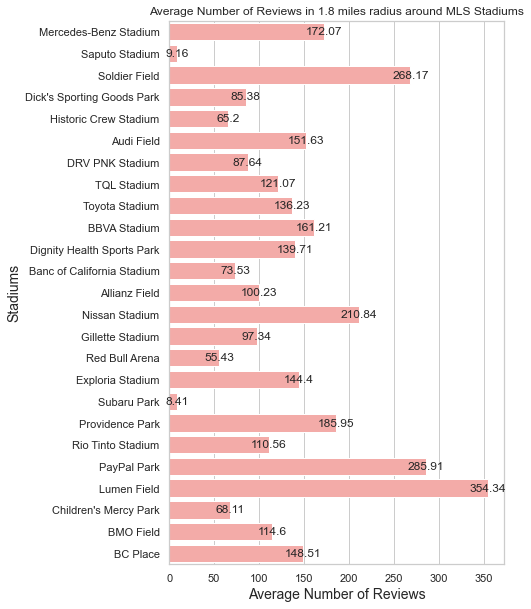

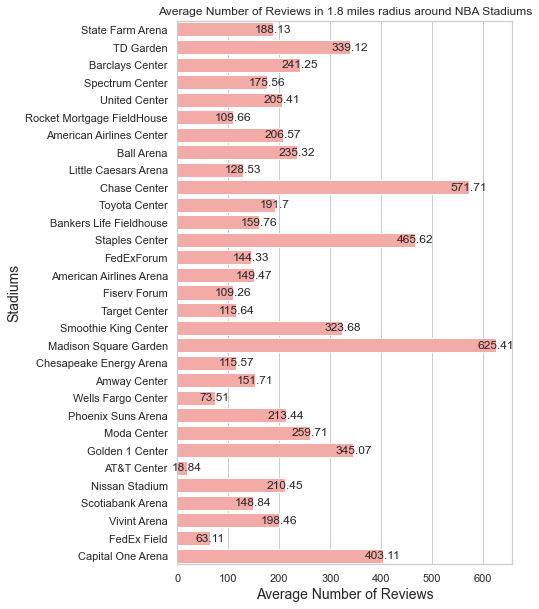

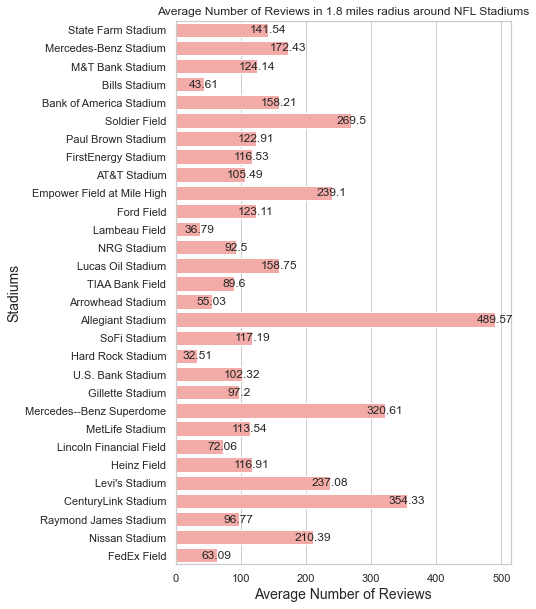

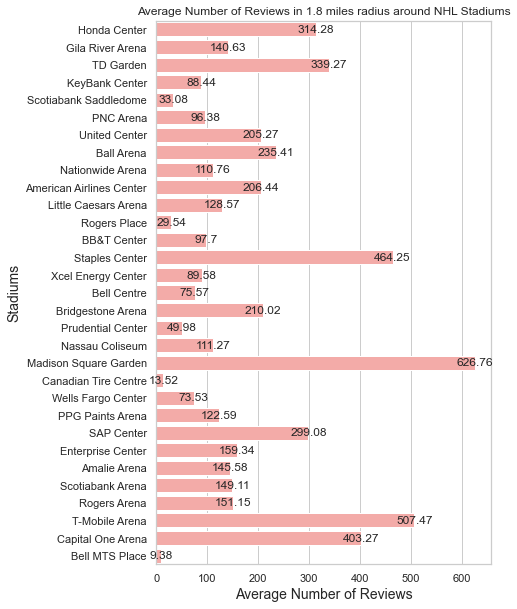

In [106]:
# Number of reviews
for k,v in stats.items():
    barPlot(k,v, "Average Number of Reviews","r", save=False)

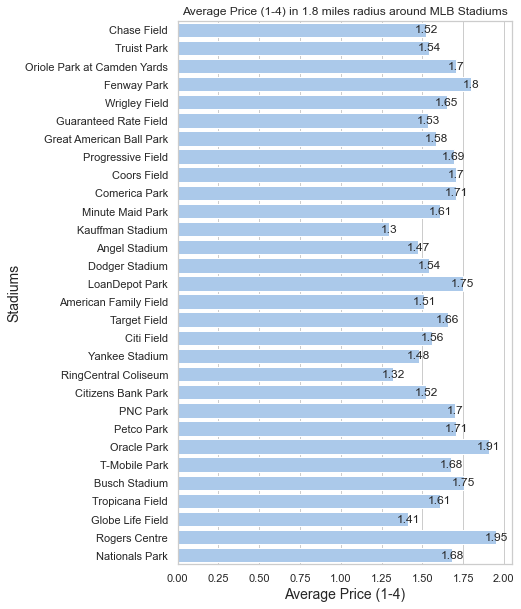

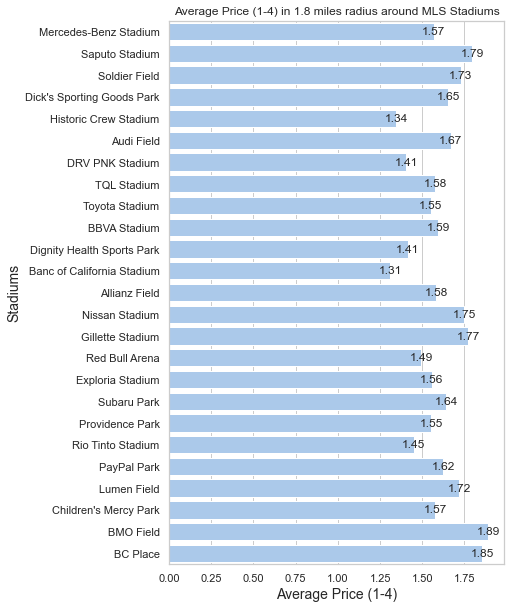

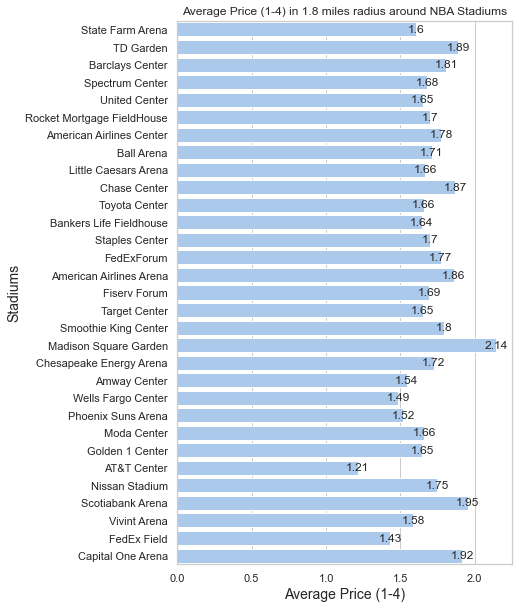

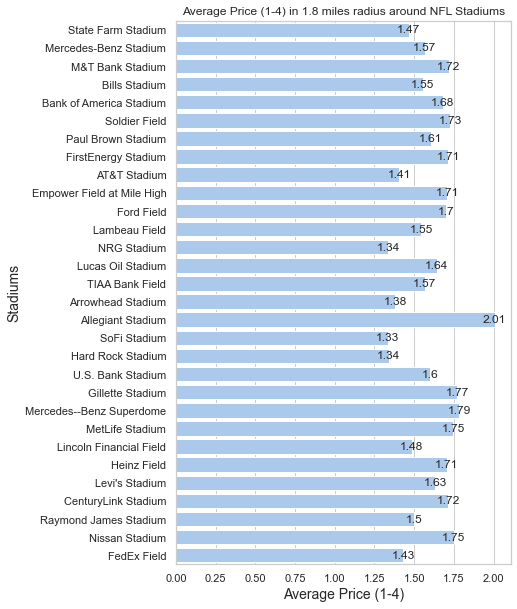

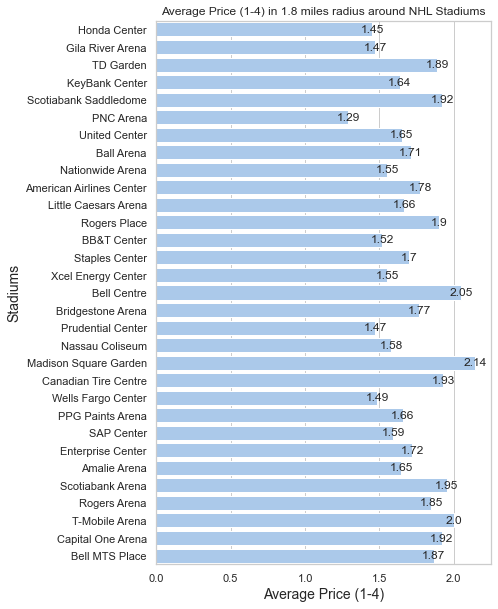

In [107]:
# Average Price 
for k,v in stats.items():
    barPlot(k,v, "Average Price (1-4)","b", save=False)

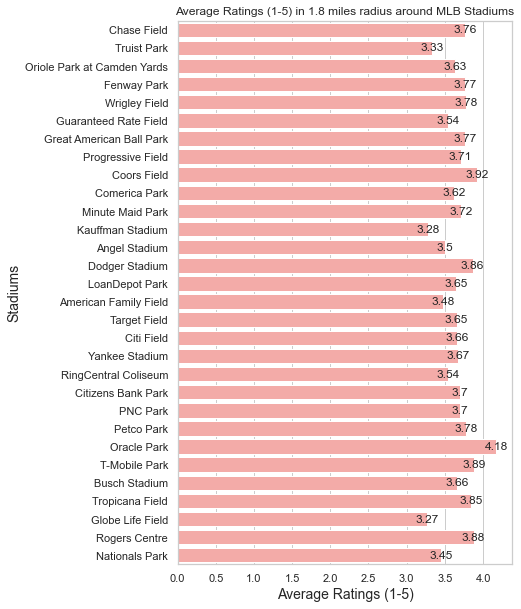

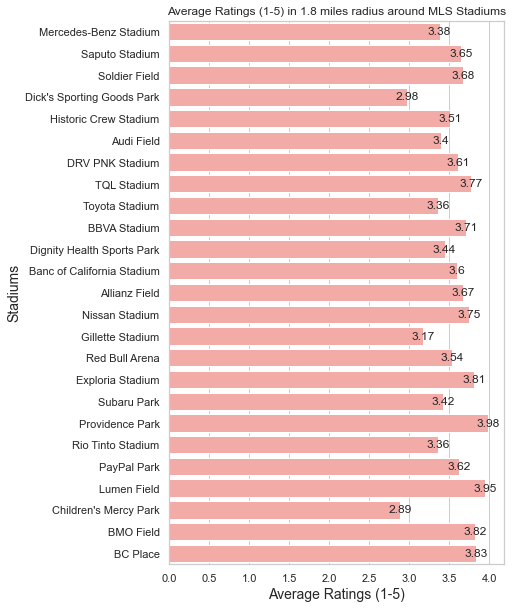

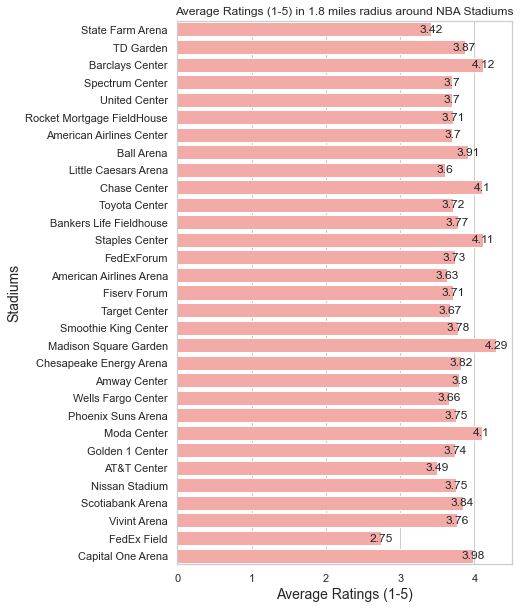

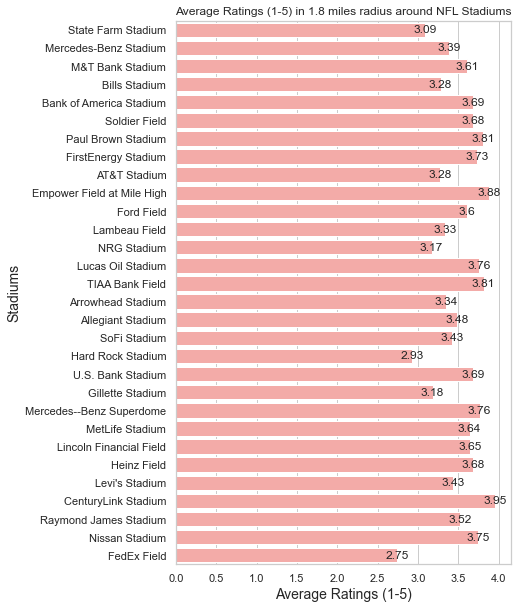

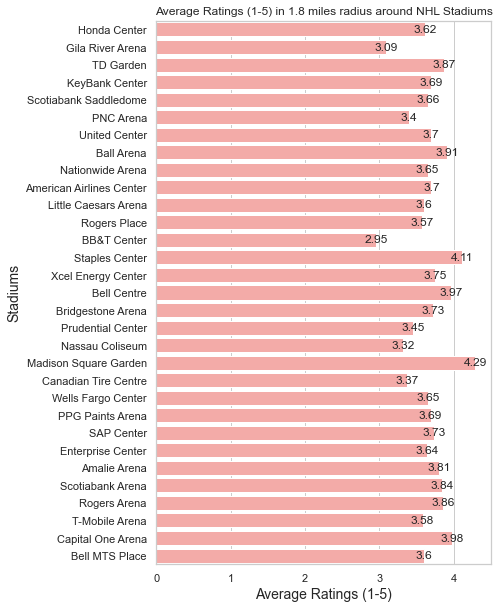

In [108]:
# Average Price 
for k,v in stats.items():
    barPlot(k,v, "Average Ratings (1-5)","r", save=False)